In [ ]:
!pip install -r dev-requirements.txt

#### 1. Load Libraries

In [23]:
import os 
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import mlflow
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW, DataCollatorWithPadding
from transformers import get_linear_schedule_with_warmup, get_scheduler
from transformers import Trainer, TrainingArguments, TrainerCallback
from transformers import pipeline
from copy import deepcopy
from datasets import load_dataset, ClassLabel
from datasets import Dataset

import torch
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix

%load_ext tensorboard

#### 2. Preprocess data

1. load CSV into dataframe 
2. Rename the columns
3. Plot distribution of Target variable

In [2]:
df = pd.read_csv('Restaurant_Reviews.csv')
df = df.rename(columns={'Review': 'text', 'Liked': 'labels'})
df.head()

,text,labels
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


<Axes: xlabel='labels'>

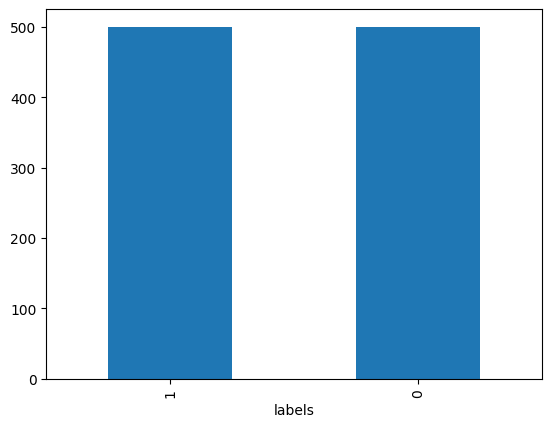

In [3]:
df.labels.value_counts().plot(kind='bar')

**Convert pandas to datasets**

In [4]:
dataset = Dataset.from_pandas(df)

**Split data into training and test dataset**

In [5]:
train_dataset = dataset.train_test_split(train_size=0.8, seed=42)

In [6]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 800
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 200
    })
})

#### 3. Tokenizer training set

In [7]:
checkpoint = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)


**Map training and test data as input for the model**

In [8]:
def tokenize_function(batch):
    return tokenizer(batch['text'], padding="max_length", truncation=True)

training_dataset = train_dataset['train'].map(tokenize_function, batched=True).shuffle(seed=42)
test_dataset = train_dataset['test'].map(tokenize_function, batched=True).shuffle(seed=42)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

#### 4. Train the model or Fine-tune base model

Replace pretraining head of BERT transformer with classification head of fine-tuned for sentimental analysis. This would enable me to transfer the knowledge from Bert to my custom model.

For training, I will be using the Trainer API, which is optimized for fine-tuning Transformer model, BERT.


**Define BERT as base model:**

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, id2label={ 0: 'negative', 1: 'positive'})

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define the metrics that will be used to evaluate how good fine-tuned model is

In [10]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = np.sum(predictions == labels) / predictions.shape[0]
    return {
        "accuracy": acc,
        "f1score": f1_score(labels, predictions)
#         
    }

**Set up a repository to log the model**

In [19]:
!huggingface-cli login --token ''

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `ade_token` has been saved to /Users/adebayoakinlalu/.cache/huggingface/stored_tokens
Your token has been saved to /Users/adebayoakinlalu/.cache/huggingface/token
Login successful.
The current active token is: `ade_token`


In [20]:
repository_name = "finetune-bert-sentiment-analysis"
training_args = TrainingArguments(
    output_dir=repository_name,       # Directory where the model checkpoints will be saved
    overwrite_output_dir = True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    eval_strategy="epoch",
    logging_dir="./logs",
    learning_rate=5e-5, # The initial learning rate for AdamW optimizer.
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=10,  # The logging strategy to adopt during training (used to log training loss for example).
    save_strategy="epoch",
    load_best_model_at_end=True,
    run_name="sentiment_model",
    push_to_hub=True,
    report_to="tensorboard"
    

)

In [21]:
trainer = Trainer(
    args=training_args,
    model=model,
    train_dataset=training_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/var/folders/hp/d6sdzrk95_50sp0qqkjzrl4m0000gn/T/ipykernel_54501/1819845714.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/300 [00:00<?, ?it/s]

{'loss': 0.7149, 'grad_norm': 4.777736186981201, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.1}
{'loss': 0.695, 'grad_norm': 9.622745513916016, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.2}
{'loss': 0.7086, 'grad_norm': 8.217219352722168, 'learning_rate': 3e-06, 'epoch': 0.3}
{'loss': 0.6791, 'grad_norm': 3.831536293029785, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.4}
{'loss': 0.6597, 'grad_norm': 5.377200126647949, 'learning_rate': 5e-06, 'epoch': 0.5}
{'loss': 0.6682, 'grad_norm': 3.4909937381744385, 'learning_rate': 6e-06, 'epoch': 0.6}
{'loss': 0.6301, 'grad_norm': 4.640346527099609, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.7}
{'loss': 0.6224, 'grad_norm': 4.6484375, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.8}
{'loss': 0.6001, 'grad_norm': 7.747264862060547, 'learning_rate': 9e-06, 'epoch': 0.9}
{'loss': 0.5361, 'grad_norm': 7.6436357498168945, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.4737967550754547, 'eval_accuracy': 0.865, 'eval_f1score': 0.8810572687224669, 'eval_runtime': 9.1276, 'eval_samples_per_second': 21.912, 'eval_steps_per_second': 2.739, 'epoch': 1.0}
{'loss': 0.4527, 'grad_norm': 9.541662216186523, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.1}
{'loss': 0.4022, 'grad_norm': 16.178499221801758, 'learning_rate': 1.2e-05, 'epoch': 1.2}
{'loss': 0.3556, 'grad_norm': 13.967970848083496, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.3}
{'loss': 0.2294, 'grad_norm': 10.450530052185059, 'learning_rate': 1.4000000000000001e-05, 'epoch': 1.4}
{'loss': 0.1445, 'grad_norm': 2.4614481925964355, 'learning_rate': 1.5e-05, 'epoch': 1.5}
{'loss': 0.1527, 'grad_norm': 1.1261848211288452, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.6}
{'loss': 0.5077, 'grad_norm': 0.5167251825332642, 'learning_rate': 1.7000000000000003e-05, 'epoch': 1.7}
{'loss': 0.3407, 'grad_norm': 3.145665407180786, 'learning_rate': 1.8e-05, 'epoch': 1.8}
{'loss':

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.2378215342760086, 'eval_accuracy': 0.94, 'eval_f1score': 0.9454545454545454, 'eval_runtime': 9.207, 'eval_samples_per_second': 21.723, 'eval_steps_per_second': 2.715, 'epoch': 2.0}
{'loss': 0.1368, 'grad_norm': 0.28859224915504456, 'learning_rate': 2.1e-05, 'epoch': 2.1}
{'loss': 0.124, 'grad_norm': 70.46224975585938, 'learning_rate': 2.2000000000000003e-05, 'epoch': 2.2}
{'loss': 0.0402, 'grad_norm': 0.08542439341545105, 'learning_rate': 2.3000000000000003e-05, 'epoch': 2.3}
{'loss': 0.0592, 'grad_norm': 0.0735195055603981, 'learning_rate': 2.4e-05, 'epoch': 2.4}
{'loss': 0.0395, 'grad_norm': 0.13195234537124634, 'learning_rate': 2.5e-05, 'epoch': 2.5}
{'loss': 0.1633, 'grad_norm': 0.3802044689655304, 'learning_rate': 2.6000000000000002e-05, 'epoch': 2.6}
{'loss': 0.0744, 'grad_norm': 3.8168463706970215, 'learning_rate': 2.7000000000000002e-05, 'epoch': 2.7}
{'loss': 0.0515, 'grad_norm': 0.055340562015771866, 'learning_rate': 2.8000000000000003e-05, 'epoch': 2.8}
{'los

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.285694420337677, 'eval_accuracy': 0.945, 'eval_f1score': 0.9506726457399103, 'eval_runtime': 9.3959, 'eval_samples_per_second': 21.286, 'eval_steps_per_second': 2.661, 'epoch': 3.0}
{'train_runtime': 380.2467, 'train_samples_per_second': 6.312, 'train_steps_per_second': 0.789, 'train_loss': 0.3404576671123505, 'epoch': 3.0}


TrainOutput(global_step=300, training_loss=0.3404576671123505, metrics={'train_runtime': 380.2467, 'train_samples_per_second': 6.312, 'train_steps_per_second': 0.789, 'total_flos': 631466532864000.0, 'train_loss': 0.3404576671123505, 'epoch': 3.0})

**Evaluate**

In [34]:
trainer.evaluate()

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.2378215342760086,
 'eval_accuracy': 0.94,
 'eval_f1score': 0.9454545454545454,
 'eval_runtime': 10.9381,
 'eval_samples_per_second': 18.285,
 'eval_steps_per_second': 2.286,
 'epoch': 3.0}

**Push to hub**

In [35]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aakinlalu/finetune-bert-sentiment-analysis/commit/d9f8cb1eef6229cdde5a0bb3e63341b51d24bd61', commit_message='End of training', commit_description='', oid='d9f8cb1eef6229cdde5a0bb3e63341b51d24bd61', pr_url=None, repo_url=RepoUrl('https://huggingface.co/aakinlalu/finetune-bert-sentiment-analysis', endpoint='https://huggingface.co', repo_type='model', repo_id='aakinlalu/finetune-bert-sentiment-analysis'), pr_revision=None, pr_num=None)

#### 5. Test the model with new data 

In [36]:
from transformers import pipeline

sentiment_model= pipeline(model="aakinlalu/finetune-bert-sentiment-analysis")

sentiment_model("It was a good movie")


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'positive', 'score': 0.993887722492218}]

In [37]:
trainer.save_model("sentiment_model")

No files have been modified since last commit. Skipping to prevent empty commit.


#### 6. Eval Stats with Tensorboard

In [29]:
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 57943), started 0:07:10 ago. (Use '!kill 57943' to kill it.)